# Select images

In [1]:
import os
import json
from PIL import Image
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification, LayoutLMv3Tokenizer, TrainingArguments, Trainer

In [2]:
from google.colab import drive
drive.mount('/content/drive')
base_path = 'drive/MyDrive/LaCuentax'
os.environ["WANDB_DISABLED"] = "true"

Mounted at /content/drive


In [3]:
# Images with end results to evaluate E2E algo
with open(f'{base_path}/uids_items.json', 'r') as f:
    uids_items = json.load(f)
uids_with_items = [item['uid'] for item in uids_items]
print('Nb images with end res:', len(uids_with_items))

# Images with word labels
files = os.listdir(f'{base_path}/texts_boxes_labels')
uids_with_labels = [f.split('.')[0] for f in files]
print('Nb images with labels:', len(uids_with_labels))


Nb images with end res: 155
Nb images with labels: 98


In [4]:
uids_train_eval = [uid for uid in uids_with_labels if uid not in uids_with_items]
uids_inference = [uid for uid in uids_with_labels if uid in uids_with_items]

print('Nb images for training and evaluation:', len(uids_train_eval))
print('Nb images for inference:', len(uids_inference))

Nb images for training and evaluation: 60
Nb images for inference: 38


In [5]:
uids_train = uids_train_eval[:int(len(uids_train_eval) * 0.8)]  # 80% for training
uids_eval = uids_train_eval[int(len(uids_train_eval) * 0.8):]  # 20% for evaluation

# Prepare dataset

In [6]:
id2label = {
    0: 'other',
    1: 'element_name',
    2: 'element_quantity',
    3: 'element_price'
}
label2id = {v: k for k, v in id2label.items()}

In [7]:
def reformat_and_normalize_boxes(raw_boxes):
    # Find the min and max coordinates from all bounding boxes
    min_x = min(min(box[0][0], box[2][0]) for box in raw_boxes)
    max_x = max(max(box[0][0], box[2][0]) for box in raw_boxes)
    min_y = min(min(box[0][1], box[2][1]) for box in raw_boxes)
    max_y = max(max(box[0][1], box[2][1]) for box in raw_boxes)

    # Normalize bboxes using Min-Max normalization to [0, 1000] scale
    bboxes_normalized = []
    for raw_boxe in raw_boxes:
        # Unpack raw bounding box
        x_min, y_min = raw_boxe[0]
        x_max, y_max = raw_boxe[2]

        # Min-Max normalization to [0, 1000]
        normalized_bbox = [
            int(1000 * (x_min - min_x) / (max_x - min_x) if max_x != min_x else 0),
            int(1000 * (y_min - min_y) / (max_y - min_y) if max_y != min_y else 0),
            int(1000 * (x_max - min_x) / (max_x - min_x) if max_x != min_x else 0),
            int(1000 * (y_max - min_y) / (max_y - min_y) if max_y != min_y else 0),
        ]

        bboxes_normalized.append(normalized_bbox)

    return bboxes_normalized

In [53]:
def prepare_dataset(uids):
    dataset = []
    for uid in uids:
        with open(f'{base_path}/texts_boxes_labels/{uid}.json', 'r') as f:
            data = json.load(f)

        dataset_el = {
            'uid': uid,
            'image_path': f'{base_path}/cuentas/{uid}.jpeg',
            'texts': data['texts'],
            'raw_boxes': data['raw_boxes'],
            'boxes': reformat_and_normalize_boxes(data['raw_boxes']),
            'labels': [label2id[label] for label in data['labels']]
        }

        dataset.append(dataset_el)

    return dataset

In [11]:
train_dataset = prepare_dataset(uids_train)
eval_dataset = prepare_dataset(uids_eval)

In [12]:
def validate_dataset(dataset):
    for i, item in enumerate(dataset):
        if len(item['boxes']) != len(item['texts']) or len(item['texts']) != len(item['labels']):
            print('Invalid lens for:', item['uid'])
            return False

        for bbox in item["boxes"]:
            if not all(0 <= coord <= 1000 for coord in bbox):
                print(f"Invalid bbox at index {i}: {bbox}, for uid", item['uid'])
                return False
    return True

In [13]:
validate_dataset(train_dataset)

True

In [14]:
validate_dataset(eval_dataset)

True

In [15]:
len(train_dataset), len(eval_dataset)

(48, 12)

In [16]:
class LayoutLMDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load image
        image = Image.open(item["image_path"]).convert("RGB")

        # Prepare inputs using LayoutLMv3Processor
        encoding = self.processor(
            images=image,
            text=item["texts"],
            boxes=item["boxes"],
            word_labels=item["labels"],
            return_tensors="pt",
            padding="max_length",
            max_length=512,
            truncation=True
        )

        return {key: val.squeeze(0) for key, val in encoding.items()}

In [17]:
model_name = "microsoft/layoutLMv3-base"

model = LayoutLMv3ForTokenClassification.from_pretrained(
    model_name,
    num_labels=4
)

processor = LayoutLMv3Processor.from_pretrained(model_name, apply_ocr=False)

train_dataset_LM = LayoutLMDataset(train_dataset, processor)
eval_dataset_LM = LayoutLMDataset(eval_dataset, processor)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutLMv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

# Define metrics

In [23]:
# pip install evaluate

In [24]:
# pip install seqeval

In [22]:
import numpy as np
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Define and train the model

In [25]:
training_args = TrainingArguments(
    output_dir=f'{base_path}/layoutlm_finetuned',
    learning_rate=2e-5,
    # per_device_train_batch_size=1,
    # per_device_eval_batch_size=1,
    # gradient_accumulation_steps=4,
    num_train_epochs=3,
    # warmup_steps=50,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_LM,
    eval_dataset=eval_dataset_LM,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

trainer.train()

<ipython-input-26-85e795114ef2>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.741414,0.234742,0.182149,0.205128,0.699683
2,No log,0.454798,0.616438,0.737705,0.671642,0.874921
3,No log,0.338610,0.702532,0.808743,0.751905,0.909206


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: element_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: element_name seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: element_price seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

TrainOutput(global_step=18, training_loss=0.6899544927808974, metrics={'train_runtime': 181.1477, 'train_samples_per_second': 0.795, 'train_steps_per_second': 0.099, 'total_flos': 37958148882432.0, 'train_loss': 0.6899544927808974, 'epoch': 3.0})

# Inference

In [65]:
inference_dataset = prepare_dataset(uids_inference)

In [66]:
from transformers import AutoModelForTokenClassification

checkpoint = 18
model_path = f'{base_path}/layoutlm_finetuned/checkpoint-{checkpoint}'

tokenizer = LayoutLMv3Tokenizer.from_pretrained(model_path)

model = AutoModelForTokenClassification.from_pretrained(model_path)

In [67]:
for i, item in enumerate(inference_dataset):

    # Load image
    image = Image.open(item["image_path"]).convert("RGB")

    # Prepare inputs using LayoutLMv3Processor
    encoding = tokenizer(
        images=image,
        text=item["texts"],
        boxes=item["boxes"],
        word_labels=item["labels"],
        return_tensors="pt",
        padding="max_length",
        max_length=512,
        truncation=True
    )

    # Make the prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**encoding)

    # Get the predicted labels (e.g., token classification labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    labels = [id2label.get(pred) for pred in predictions.tolist()[0]]

    labels_word_level = []
    for id, label in zip(encoding['input_ids'][0].tolist(), labels):
        token = tokenizer.decode([id])

        # Keep the label of the first token of a word
        if id not in [tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id] and token.startswith(' '):
            labels_word_level.append(label)

    inference_dataset[i]['predicted_labels'] = labels_word_level

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [74]:
from seqeval.metrics import classification_report

true_labels = [item["labels"] for item in inference_dataset]
predicted_labels = [item["predicted_labels"] for item in inference_dataset]

# Pad predictions for any missing labels:
max_len = max(map(len, true_labels))
predicted_labels_padded = [prediction + ["other"] * (max_len - len(prediction)) for prediction in predicted_labels]
true_labels_padded = [[id2label[lab] for lab in labels] + ["other"] * (max_len - len(labels)) for labels in true_labels]

# Compute metrics
report = classification_report(true_labels_padded, predicted_labels_padded)
print(report)

# Using the evaluate library
metric = evaluate.load("seqeval")
results = metric.compute(predictions=predicted_labels_padded, references=true_labels_padded)
print(results)

                 precision    recall  f1-score   support

    lement_name       0.46      0.36      0.40       338
   lement_price       0.77      0.37      0.50       377
lement_quantity       1.00      0.27      0.42       319
           ther       0.20      0.24      0.22       369

      micro avg       0.45      0.31      0.37      1403
      macro avg       0.61      0.31      0.38      1403
   weighted avg       0.60      0.31      0.38      1403

{'lement_name': {'precision': np.float64(0.46153846153846156), 'recall': np.float64(0.35502958579881655), 'f1': np.float64(0.4013377926421405), 'number': np.int64(338)}, 'lement_price': {'precision': np.float64(0.7722222222222223), 'recall': np.float64(0.3687002652519894), 'f1': np.float64(0.49910233393177733), 'number': np.int64(377)}, 'lement_quantity': {'precision': np.float64(1.0), 'recall': np.float64(0.2664576802507837), 'f1': np.float64(0.42079207920792083), 'number': np.int64(319)}, 'ther': {'precision': np.float64(0.2009237875

In [68]:
def plot_predictions(item):
    color_mapping = {
        'element_quantity': (0, 255, 0),  # green
        'element_name': (0, 255, 255),  # cyan
        'element_price': (0, 0, 255),  # blue
        'other': (255, 0, 0),  # red
    }


    image = cv2.imread(item['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for text, box, label in zip(item['texts'], item['raw_boxes'], item['predicted_labels']):
        color = color_mapping.get(label)

        cv2.line(image, box[0], box[1], color, 2)
        cv2.line(image, box[1], box[2], color, 2)
        cv2.line(image, box[2], box[3], color, 2)
        cv2.line(image, box[3], box[0], color, 2)

    plt.figure(figsize=(7, 14))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

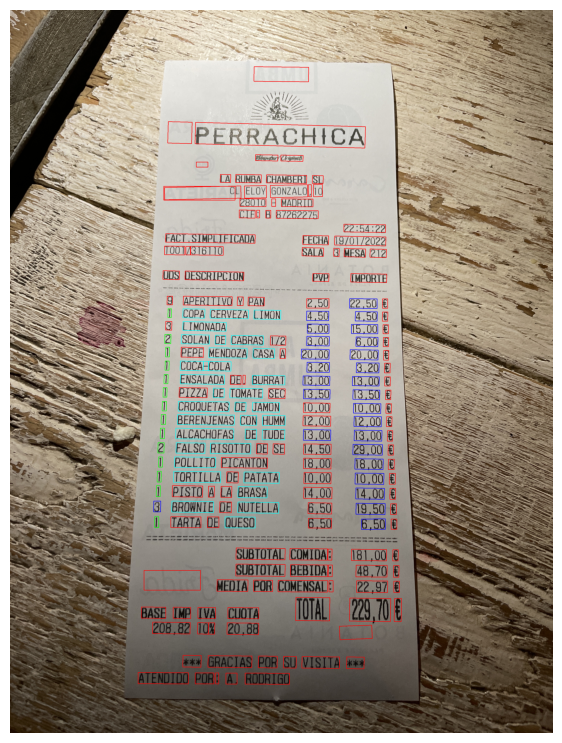

In [70]:
plot_predictions(inference_dataset[0])

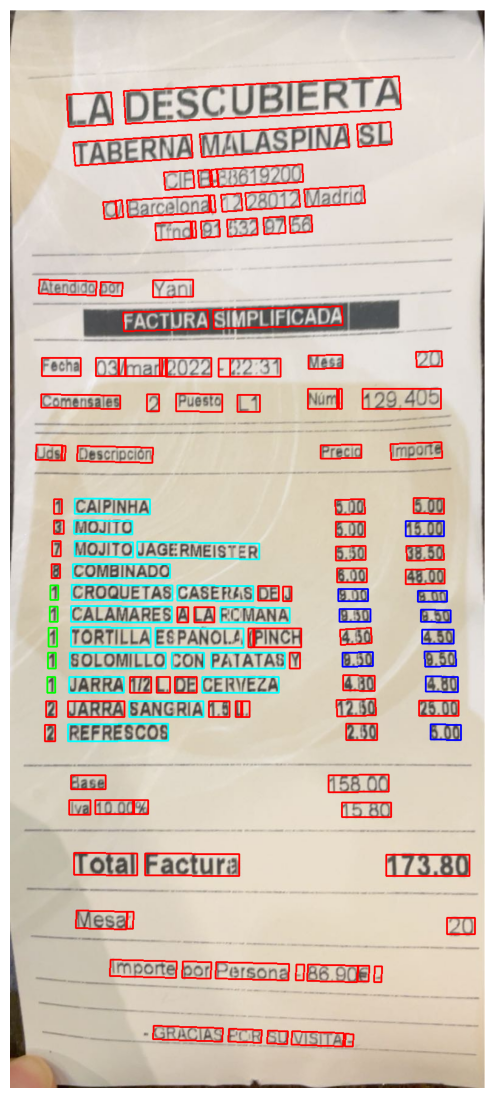

In [58]:
plot_predictions(inference_dataset[1])

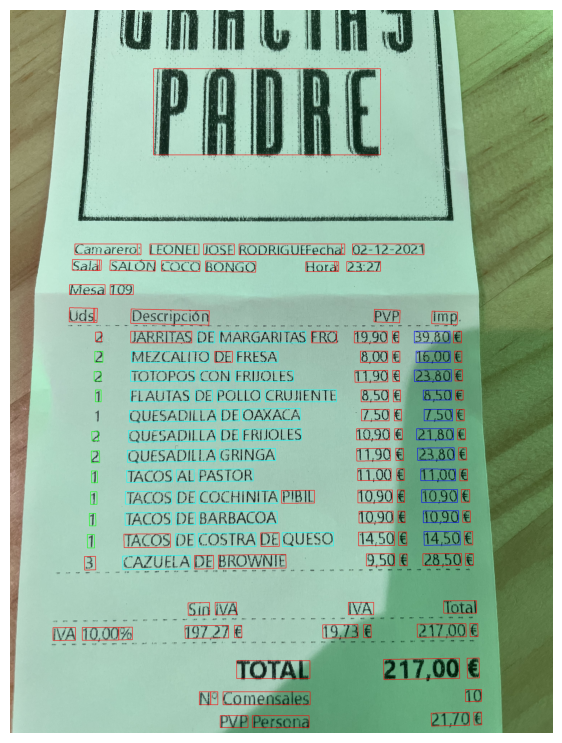

In [59]:
plot_predictions(inference_dataset[2])

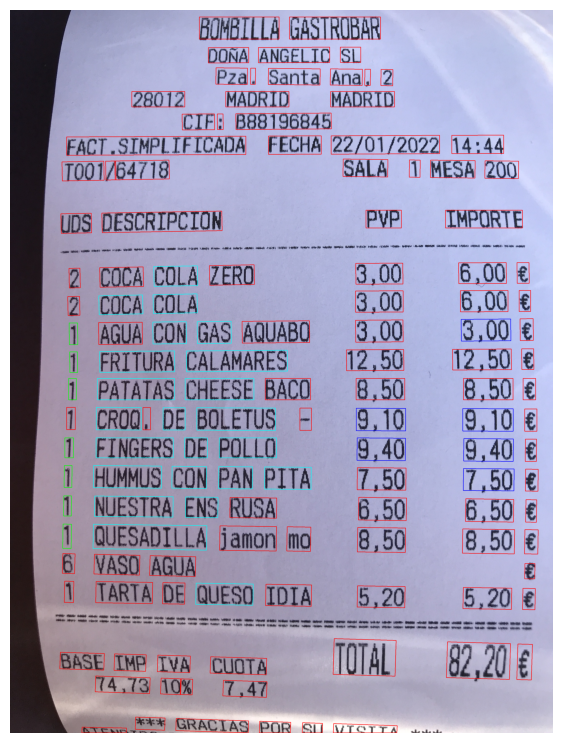

In [85]:
plot_predictions(inference_dataset[23])

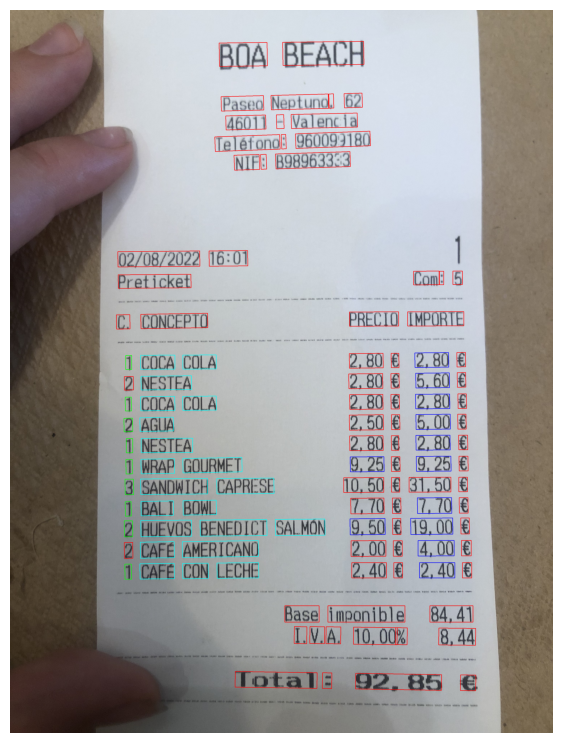

In [87]:
plot_predictions(inference_dataset[29])